In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os

In [2]:
#print the list of paths of files in the training set
set_path = 'train'
paths = sorted(glob.glob(f'data/{set_path}/*.hdf5'))
print(paths)

['data/train/MHDMa_0.7_Ms_0.5.hdf5', 'data/train/MHDMa_0.7_Ms_0.7.hdf5', 'data/train/MHDMa_0.7_Ms_1.5.hdf5', 'data/train/MHDMa_0.7_Ms_2.hdf5', 'data/train/MHDMa_0.7_Ms_7.hdf5', 'data/train/MHDMa_2_Ms_0.5.hdf5', 'data/train/MHDMa_2_Ms_0.7.hdf5', 'data/train/MHDMa_2_Ms_1.5.hdf5', 'data/train/MHDMa_2_Ms_2.hdf5', 'data/train/MHDMa_2_Ms_7.hdf5']


In [3]:
#select the first path (arbitrary choice)
p = paths[0]

#print the first layer of keys
with h5py.File(p,'r') as f:
    print(f.keys())

<KeysViewHDF5 ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']>


In [4]:
# In 'boundary_conditions' is stored the information about the boundary conditions:
with h5py.File(p,'r') as f:
    print('print bc available:', f['boundary_conditions'].keys())
    print('print attributes of the bc:', f['boundary_conditions']['x_periodic'].attrs.keys())
    print('get the bc type:', f['boundary_conditions']['x_periodic'].attrs['bc_type'])

print bc available: <KeysViewHDF5 ['x_periodic', 'y_periodic', 'z_periodic']>
print attributes of the bc: <KeysViewHDF5 ['associated_dims', 'associated_fields', 'bc_type', 'sample_varying', 'time_varying']>
get the bc type: periodic


In [5]:
#Reminder: 't0_fields', 't1_fields', 't2_fields' are respectively scalar fields, vector fields and tensor fields
#print the different fields available in the dataset
with h5py.File(p,'r') as f:
    print('t0_fields:', f['t0_fields'].keys())
    print('t1_fields:', f['t1_fields'].keys())
    print('t2_fields:', f['t2_fields'].keys())

t0_fields: <KeysViewHDF5 ['density']>
t1_fields: <KeysViewHDF5 ['magnetic_field', 'velocity']>
t2_fields: <KeysViewHDF5 []>


In [6]:
#The data is of shape (n_trajectories, n_timesteps, x, y, z)
#Get the first t0_field and save it as a numpy array
traj = 0
with h5py.File(p,'r') as f:
    density = f['t0_fields']['density'][traj,:] #HDF5 datasets can be sliced like a numpy array
    print(f'shape of the selected t0_field: ',density.shape)   
    #you can directly slice the selected field without reading the whole dataset by doing:
    #traj = 0 #select the trajectory
    # field = f['t0_fields']['concentration'][traj, :] 

shape of the selected t0_field:  (100, 64, 64, 64)


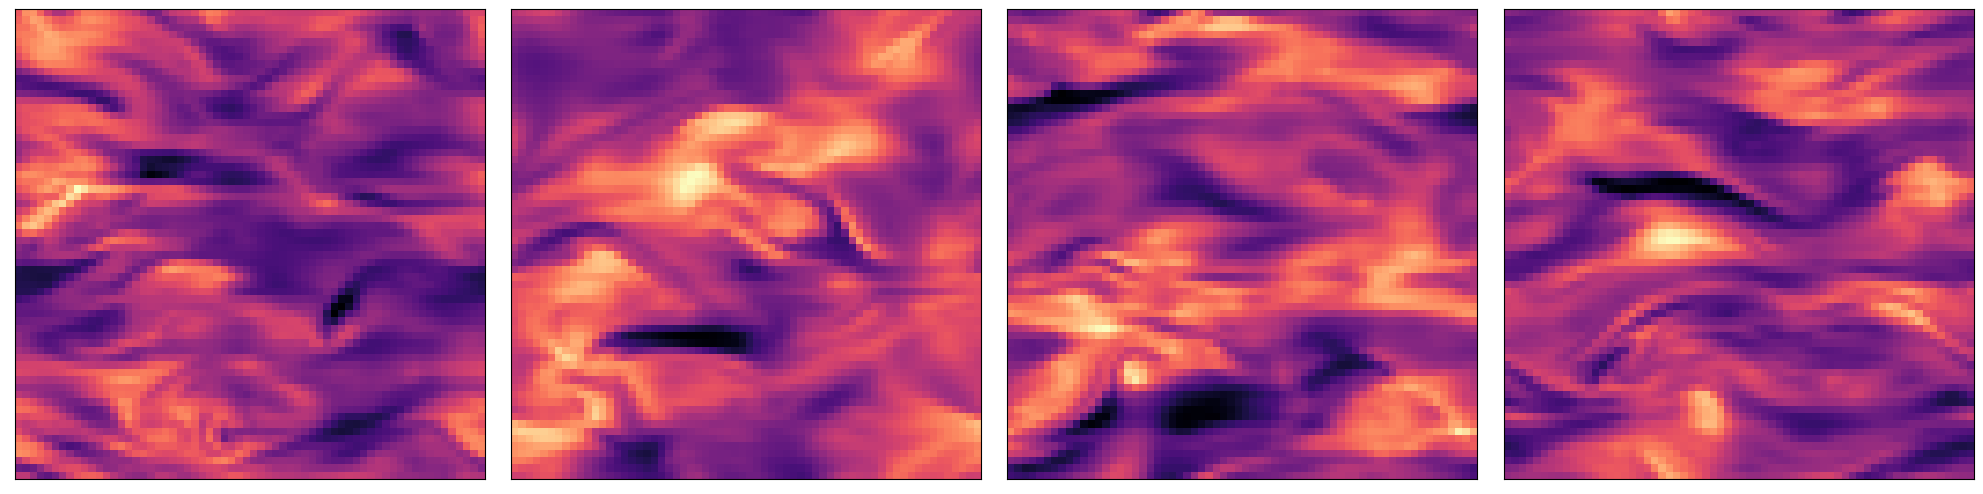

In [7]:
from matplotlib.colors import LogNorm

x_slice = 32
traj_toplot = density[:,x_slice,:,:]
#field is now of shape (n_timesteps, x, y). Let's do a subplot to plot it at t= 0, t= T/3, t= 2T/3 and t= T:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
T = traj_toplot.shape[0]
#fix colorbar for all subplots:
normalize_plots = False #True
cmap =  'magma' #'RdBu_r' #'viridis' #'magma'
if normalize_plots:
    vmin = np.nanmin(traj_toplot)
    vmax = np.nanmax(traj_toplot)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
        axs[i].imshow(traj_toplot[t], cmap=cmap, norm=norm)
        axs[i].set_xticks([])
        axs[i].set_yticks([])



else:
    for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
        axs[i].imshow(traj_toplot[t], cmap=cmap)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        #axs[i].set_title(f't={t}')
plt.tight_layout()




In [14]:
#save figure without axes and titles:

image_name = 'MHD_density_unnormalized'
path_to_save = '/mnt/home/polymathic/ceph/the_well/viz/'
fig.savefig(f'{path_to_save}{image_name}.png', bbox_inches='tight', pad_inches=0.05)

In [18]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
def create_gif(time_series, saving_directory, name_file = 'concentration', delete_imgs=False, normalize = True):
    time_series_min = time_series.min()
    time_series_max = time_series.max()
    if time_series.ndim > 3:
        #error:
        print('Error: The time series should be (time, height, width)')
        return
    if not os.path.exists(saving_directory + '/img_for_gif'):
        os.makedirs(saving_directory + '/img_for_gif')
    images = []
    cmap = 'magma' #'RdBu_r' #'viridis'
    for i in range(time_series.shape[0]):
        if normalize:
            plt.imshow(time_series[i], origin='lower',cmap=cmap, vmin=time_series_min, vmax=time_series_max);
        else:
            plt.imshow(time_series[i], cmap=cmap, origin='lower')#, vmin=time_series_min, vmax=time_series_max);
        #plt.show()
        plt.axis('off')
        plt.savefig(saving_directory + f'/img_for_gif/time_series_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()
        images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))

    imageio.mimsave(saving_directory + '/' + name_file + '.gif', images, duration=0.1)
    if delete_imgs:
        shutil.rmtree(saving_directory + '/img_for_gif')



create_gif(traj_toplot, 'gif', name_file='density_unnormalized', delete_imgs=True, normalize = False)

/tmp/ipykernel_3632352/189584949.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))


In [8]:
#Check dataset
#TEST
import h5py as h5
import numpy as np


def check_dimensions(f):
    """Check that the dimensions group of the file
    is in the correct format for the well dataset"""
    print('Checking the formatting of "dimensions" group')
    dims = f["dimensions"]
    assert "time" in dims, "Group 'dimensions must contain a 'time' dataset"
    assert (
        "sample_varying" in dims["time"].attrs
    ), "Dataset 'time' must have a 'sample_varying' attribute"
    assert isinstance(dims['time'].attrs["sample_varying"], (bool, np.bool_)), "Dataset 'time' must have a 'sample_varying' attribute of type bool"
    assert (
        "spatial_dims" in dims.attrs
    ), "Group 'dimensions' must contain a 'spatial_dims' attribute"
    assert isinstance(dims.attrs["spatial_dims"], (list, np.ndarray)), "Attribute 'spatial_dims' must be a list"
    assert isinstance(dims.attrs["spatial_dims"][0], str), "Attribute 'spatial_dims' must be a list of strings"
    assert (
        len(dims.attrs["spatial_dims"]) == f.attrs["n_spatial_dims"]
    ), "Mismatch between n_spatial_dims and spatial_dims"
    assert f.attrs["n_spatial_dims"] > 0, "Attribute 'n_spatial_dims' must be greater than 0"
    # Check if all spatial dimensions have corresponding datasets
    for d in dims.attrs["spatial_dims"]:
        assert d in dims, f"Dimension {d} not found in 'dimensions' group"
        assert (
            "sample_varying" in dims[d].attrs
        ), f"Dimension {d} must have a 'sample_varying' attribute"
        assert isinstance(
            dims[d].attrs["sample_varying"], (bool, np.bool_)
        ), f"Dimension {d} must have a 'sample_varying' attribute of type bool"
        
        assert (
            "time_varying" in dims[d].attrs
        ), f"Dimension {d} must have a 'time_varying' attribute"
        assert isinstance(
            dims[d].attrs["time_varying"], (bool, np.bool_)
        ), f"Dimension {d} must have a 'time_varying' attribute of type bool"
    print('Dimensions passed!')


def check_fields(f, tensor_order):
    """Check that the fields group of the file
    is in the correct format for the well dataset"""
    group = f"t{tensor_order}_fields"
    print(f'Checking the formatting of {group} group!')
    fields = f[group]
    dimensions = f["dimensions"]
    spatial_dims = dimensions.attrs["spatial_dims"]
    # Check field names are set up
    assert "field_names" in fields.attrs, "Group must contain a 'field_names' attribute"
    assert isinstance(fields.attrs["field_names"], (list, np.ndarray)), "Attribute 'field_names' must be a list"
    if len(fields.attrs["field_names"]) > 0:
        assert isinstance(fields.attrs["field_names"][0], str), "Attribute 'field_names' must be a list of strings"
    # Check each field is set up
    for field in fields.attrs["field_names"]:
        # Check if the field is defined, then check for boolean flags sample and time varying and list of booleans dim_varying
        dim_count = 0
        assert field in fields, f"Field {field} named, but not found in {group} group"
        # Sample dimension checking
        assert (
            "sample_varying" in fields[field].attrs
        ), f"Dataset {field} must have a 'sample_varying' attribute"
        assert isinstance(
            fields[field].attrs["sample_varying"], (bool, np.bool_)
        ), f"Dataset {field} must have a 'sample_varying' attribute of type bool"
        if fields[field].attrs["sample_varying"]:
            assert fields[field].shape[0] == f.attrs["n_trajectories"], f"Sample dimension size does not match field {field} size"
            dim_count += 1
        # Time dimension checking
        assert (
            "time_varying" in fields[field].attrs
        ), f"Dataset {field} must have a 'time_varying' attribute"
        assert isinstance(
            fields[field].attrs["time_varying"], (bool, np.bool_)
        ), f"Dataset {field} must have a 'time_varying' attribute of type bool"
        if fields[field].attrs["time_varying"]:
            assert fields[field].shape[dim_count] == dimensions["time"].shape[-1], f"Time dimension size does not match field {field} size"
            dim_count += 1
        # Space dimension checking
        assert (
            "dim_varying" in fields[field].attrs
        ), f"Dataset {field} must have a 'dim_varying' attribute"
        assert isinstance(
            fields[field].attrs["dim_varying"], (list, np.ndarray)
        ), f"Dataset {field} must have a 'dim_varying' attribute of type list"
        assert (
            len(fields[field].attrs["dim_varying"]) == len(spatial_dims)
        ), f"Dataset {field} must have a 'dim_varying' attribute of length n_spatial_dims"
        assert isinstance(
            fields[field].attrs["dim_varying"][0], (bool, np.bool_)
        ), f"Dataset {field} must have a 'dim_varying' list with bool entries"
        for i, dim in enumerate(spatial_dims):
            if fields[field].attrs["dim_varying"][i]:
                print(dim, fields[field].shape[dim_count])
                print(dimensions[dim].shape[-1])
                print(dim_count)
                assert dimensions[dim].shape[-1] == fields[field].shape[dim_count], f"Dimension {dim} size does not match field {field} size"
                dim_count += 1
    print(f'Fields in {group} passed!')

def check_scalars(f):
    print('Checking the formatting of "scalars" group')
    scalars = f["scalars"]
    assert "field_names" in scalars.attrs, "Group must contain a 'scalar_names' attribute"
    assert isinstance(scalars.attrs["field_names"], (list, np.ndarray)), "Attribute 'scalar_names' must be a list"
    if len(scalars.attrs["field_names"]) > 0:
        assert isinstance(scalars.attrs["field_names"][0], str), "Attribute 'scalar_names' must be a list of strings"
    for field in scalars.attrs["field_names"]:
        assert field in scalars, f"Field {field} named, but not found in 'scalars' group"
        assert "sample_varying" in scalars[field].attrs, f"Dataset {field} must have a 'sample_varying' attribute"
        assert isinstance(scalars[field].attrs["sample_varying"], (bool, np.bool_)), f"Dataset {field} must have a 'sample_varying' attribute of type bool"
        assert "time_varying" in scalars[field].attrs, f"Dataset {field} must have a 'time_varying' attribute"
        assert isinstance(scalars[field].attrs["time_varying"], (bool, np.bool_)), f"Dataset {field} must have a 'time_varying' attribute of type bool"
        dim_count = scalars[field].attrs["sample_varying"] + scalars[field].attrs["time_varying"]
        assert len(scalars[field].shape) == dim_count, f"Dataset {field} must have {dim_count} dimensions"
    print('Scalars passed!')

def check_boundary_conditions(f):
    print('Checking the formatting of "boundary_conditions" group')
    bcs = f["boundary_conditions"]
    dimensions = f["dimensions"]
    spatial_dims = dimensions.attrs["spatial_dims"]
    for key in f["boundary_conditions"]:
        bc = bcs[key]
        assert 'bc_type' in bc.attrs, "Group must contain a 'bc_type' attribute"
        assert "sample_varying" in bc.attrs, "Group must contain a 'sample_varying' attribute"
        assert isinstance(bc.attrs["sample_varying"], (bool, np.bool_)), "Attribute 'sample_varying' must be a boolean"
        assert "time_varying" in bc.attrs, "Group must contain a 'time_varying' attribute"
        assert isinstance(bc.attrs["time_varying"], (bool, np.bool_)), "Attribute 'time_varying' must be a boolean"
        assert "associated_fields" in bc.attrs, "Group must contain a 'associated_fields' attribute"
        dim_count = bc.attrs["sample_varying"] + bc.attrs["time_varying"]
        assert "associated_dims" in bc.attrs, "Group must contain a 'associated_dims' attribute"
        assert isinstance(bc.attrs["associated_dims"], (list, np.ndarray)), "Attribute 'associated_dims' must be a list"
        assert 'mask' in bc, "Group must contain a 'mask' dataset"
        assert len(bc.attrs["associated_dims"]) > 0, "Attribute 'associated_dims' must have at least one entry"
        for i, dim in enumerate(bc.attrs["associated_dims"]):
            assert dim in spatial_dims, f"Dimension {dim} not found in 'spatial_dims'"
            assert bc['mask'].shape[dim_count+i] == dimensions[dim].shape[-1], f"Dimension {dim} size does not match mask size"
    print('Boundary conditions passed!')

def check_hdf5_format(path: str):
    """Check that the HDF5 file is in the correct format for the well dataset"""
    with h5.File(path, "r") as f:
        # Start by checking top level attributes
        print('Checking top level attributes')
        assert "n_spatial_dims" in f.attrs, "n_spatial_dims is required root attribute"
        assert isinstance(int(f.attrs['n_spatial_dims']), (int, np.integer)), "n_spatial_dims must be an integer"
        assert "n_trajectories" in f.attrs, "n_trajectories is required root attribute"
        assert isinstance(f.attrs['n_trajectories'], (int, np.integer)), "n_trajectories must be an integer"
        assert "dataset_name" in f.attrs, "dataset_name is required root attribute"
        assert isinstance(f.attrs['dataset_name'], str), "dataset_name must be a string"
        assert "grid_type" in f.attrs, "grid_type is required root attribute"
        assert isinstance(f.attrs['grid_type'], str), "grid_type must be a string"
        assert (
            "simulation_parameters" in f.attrs
        ), "simulation_parameters is required root attribute"
        for sim_param in f.attrs["simulation_parameters"]:
            assert (
                sim_param in f.attrs
            ), f"Every listed simulation parameter should be included at attribute"
        print('Top level attributes passed!')
        assert "dimensions" in f, "No dimensions group found in HDF5 file"
        check_dimensions(f)
        for i in range(3):
            assert f"t{i}_fields" in f, f"No t{i}_fields group found in HDF5 file"
            check_fields(f, i)
        assert "scalars" in f, "No scalars found in HDF5 file"
        check_scalars(f)
        assert "boundary_conditions" in f, "No boundary_conditions found in HDF5 file"
        check_boundary_conditions(f)
        print("HDF5 file validation passed!")



In [9]:
p = '/mnt/home/polymathic/ceph/the_well/datasets/MHD_64/data/train/MHDMa_0.7_Ms_0.5.hdf5'
check_hdf5_format(p)

Checking top level attributes
Top level attributes passed!
Checking the formatting of "dimensions" group
Dimensions passed!
Checking the formatting of t0_fields group!
x 64
64
2
y 64
64
3
z 64
64
4
Fields in t0_fields passed!
Checking the formatting of t1_fields group!
x 64
64
2
y 64
64
3
z 64
64
4
Fields in t1_fields passed!
Checking the formatting of t2_fields group!
Fields in t2_fields passed!
Checking the formatting of "scalars" group
Scalars passed!
Checking the formatting of "boundary_conditions" group
Boundary conditions passed!
HDF5 file validation passed!
